In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [19]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pymorphy2

def clean_data(source_test_data: pd.DataFrame, text_field='text') -> pd.DataFrame:
    df = source_test_data.copy()
    df = df.drop(['Unnamed: 0'], axis=1)
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace("\"", "")
    df[text_field] = df[text_field].str.replace("“", "")
    df[text_field] = df[text_field].str.replace("`", "")
    df[text_field] = df[text_field].str.replace("”", "")
    df[text_field] = df[text_field].str.lower()
    return df

def prepare_data_for_modeling(source_test_data: pd.DataFrame, text_field='text') -> pd.DataFrame:
    df = source_test_data.copy()
    df = clean_data(df, text_field)
    # Токенизация
    tokenizer = RegexpTokenizer(r'\w+') 
    df['token'] = df['text'].apply(lambda x: tokenizer.tokenize(x))

    # Удаление стоп-слов
    stop_words = set(stopwords.words('russian'))
    df['token'] = df['token'].apply(lambda x: [word for word in x if word not in stop_words])

    # Лемматизация
    morph = pymorphy2.MorphAnalyzer()

    def lemmatize_text(tokens):
        return [morph.parse(token)[0].normal_form for token in tokens]
    
    df['lemmatized'] = df['token'].apply(lemmatize_text)
    return df

In [3]:
source_test_data = pd.read_csv('../data/test_data.csv')
source_test_data.head()

,Unnamed: 0,text,label
0,0,"""Как оплатить штрафы через ваш банк?""",1
1,1,Хочу взять автокредит. Какие документы необход...,4
2,2,“Как избежать комиссии при снятии наличных за ...,3
3,3,Хочу оформить ипотеку. Какие условия?,4
4,4,“Увеличится ли кредитный лимит. если я не допу...,2


Посмотрим основные параметры датасета: размерность, наличие пропусков в данных.
Заметим, что в данных нету пропусков, но есть лишний столбец.

In [4]:
source_test_data.info()
source_test_data.describe()
source_test_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  197 non-null    int64 
 1   text        197 non-null    object
 2   label       197 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.7+ KB


Unnamed: 0    0
text          0
label         0
dtype: int64

Посчитаем количество выражений в каждом классе, заметим, что распределены они примерно поровну

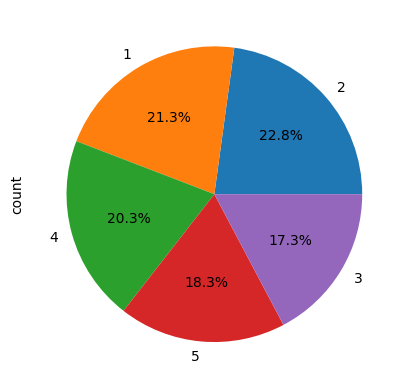

In [5]:
source_test_data['label'].value_counts().plot.pie(autopct="%.1f%%")
plt.show()

### Предобработка данных (тестирование методов предобработки, далее они все будут вынесены в общую функцию prepare_data_for_modelling)

Очистим данные от лишних символов. Посмотрев небольшую выборку данных, заметим, что есть предложения, в которых основная мысль идёт до точки, а после идёт уточняющий вопрос. "Например: хочу оформить ипотеку. какие условия?"
Имеет смысл разбить предложения на части, где дополнительные вопросы после точки относить в 5 категорию.

In [6]:
cleaned_data = clean_data(source_test_data)
cleaned_data.head()

,text,label
0,как оплатить штрафы через ваш банк?,1
1,хочу взять автокредит. какие документы необход...,4
2,как избежать комиссии при снятии наличных за г...,3
3,хочу оформить ипотеку. какие условия?,4
4,увеличится ли кредитный лимит. если я не допущ...,2


Проведём токенизацию текста

In [7]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

cleaned_data["tokens"] = cleaned_data["text"].apply(tokenizer.tokenize)
cleaned_data.head()

,text,label,tokens
0,как оплатить штрафы через ваш банк?,1,"[как, оплатить, штрафы, через, ваш, банк]"
1,хочу взять автокредит. какие документы необход...,4,"[хочу, взять, автокредит, какие, документы, не..."
2,как избежать комиссии при снятии наличных за г...,3,"[как, избежать, комиссии, при, снятии, наличны..."
3,хочу оформить ипотеку. какие условия?,4,"[хочу, оформить, ипотеку, какие, условия]"
4,увеличится ли кредитный лимит. если я не допущ...,2,"[увеличится, ли, кредитный, лимит, если, я, не..."


Очистим токены от стоп-слов

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))
cleaned_data['tokens'] = cleaned_data['tokens'].apply(lambda x: [item for item in x if item not in stop_words])
cleaned_data.head()

,text,label,tokens
0,как оплатить штрафы через ваш банк?,1,"[оплатить, штрафы, ваш, банк]"
1,хочу взять автокредит. какие документы необход...,4,"[хочу, взять, автокредит, какие, документы, не..."
2,как избежать комиссии при снятии наличных за г...,3,"[избежать, комиссии, снятии, наличных, границей]"
3,хочу оформить ипотеку. какие условия?,4,"[хочу, оформить, ипотеку, какие, условия]"
4,увеличится ли кредитный лимит. если я не допущ...,2,"[увеличится, кредитный, лимит, допущу, просроч..."


Так как объем данных небольшой, то имеется возможность провести лемматизацию текста. Используем pymorphy2 вместо nltk, так как nltk не поддерживает русского языка для лемматизации

In [10]:
import pymorphy2

full_prepared_data = cleaned_data.copy()

morph = pymorphy2.MorphAnalyzer()

def lemmatize_text(tokens):
    return [morph.parse(token)[0].normal_form for token in tokens]

full_prepared_data["lemmatized_tokens"] = full_prepared_data["tokens"].apply(lemmatize_text)
full_prepared_data.head()

,text,label,tokens,lemmatized_tokens
0,как оплатить штрафы через ваш банк?,1,"[оплатить, штрафы, ваш, банк]","[оплатить, штраф, ваш, банк]"
1,хочу взять автокредит. какие документы необход...,4,"[хочу, взять, автокредит, какие, документы, не...","[хотеть, взять, автокредит, какой, документ, н..."
2,как избежать комиссии при снятии наличных за г...,3,"[избежать, комиссии, снятии, наличных, границей]","[избежать, комиссия, снятие, наличный, граница]"
3,хочу оформить ипотеку. какие условия?,4,"[хочу, оформить, ипотеку, какие, условия]","[хотеть, оформить, ипотека, какой, условие]"
4,увеличится ли кредитный лимит. если я не допущ...,2,"[увеличится, кредитный, лимит, допущу, просроч...","[увеличиться, кредитный, лимит, допустить, про..."


### Используемые модели

In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

def plot_confusion_matrix(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.show()

def MultinomialNB_Model(X_train, X_test, y_train, y_test):
    from sklearn.naive_bayes import MultinomialNB
    clf = MultinomialNB()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("MultinomialNB", classification_report(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
    plot_confusion_matrix(y_test, y_pred)
    return clf

def LogisticRegression_Model(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("LogisticRegression", classification_report(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
    plot_confusion_matrix(y_test, y_pred)
    return clf

def ExtraTreesClassifier_Model(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import ExtraTreesClassifier
    clf = ExtraTreesClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("ExtraTreesClassifier", classification_report(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
    plot_confusion_matrix(y_test, y_pred)
    return clf

def RandomForestClassifier_Model(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("RandomForestClassifier", classification_report(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
    plot_confusion_matrix(y_test, y_pred)
    return clf

def Kmeans_Model(X_train, X_test, y_train, y_test):
    from sklearn.cluster import KMeans
    clf = KMeans(n_clusters=2)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("KMeans", classification_report(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
    plot_confusion_matrix(y_test, y_pred)
    return clf

### TFIDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = full_prepared_data['lemmatized_tokens'].apply(lambda x: ' '.join(x))
y = full_prepared_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()


X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = X_train.toarray()[0]
tfidf_scores = list(zip(feature_names, tfidf_scores))

tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
tfidf_scores[:10]

[('адрес', 0.46910100308184094),
 ('доставка', 0.46910100308184094),
 ('заказ', 0.43367760496822727),
 ('изменить', 0.373120905914967),
 ('сайт', 0.373120905914967),
 ('оплатить', 0.30557128775889975),
 ('000', 0.0),
 ('10', 0.0),
 ('sms', 0.0),
 ('автокредит', 0.0)]

Попробуем обучить несколько моделей с использованием полученных векторов.
В ходе обучения стало понятно, что данных слишком мало для того, чтобы строить эффективные решающие деревья.
KMeans плохо подходит из-за трудности пространственного представления векторов TFIDF.
Лучше всего себя показала логистическая регрессия.

MultinomialNB               precision    recall  f1-score   support

           1       0.83      0.50      0.62        10
           2       0.67      0.83      0.74        12
           3       1.00      0.88      0.93         8
           4       0.71      0.83      0.77         6
           5       0.60      0.75      0.67         4

    accuracy                           0.75        40
   macro avg       0.76      0.76      0.75        40
weighted avg       0.78      0.75      0.75        40

F1 Score:  0.746994301994302


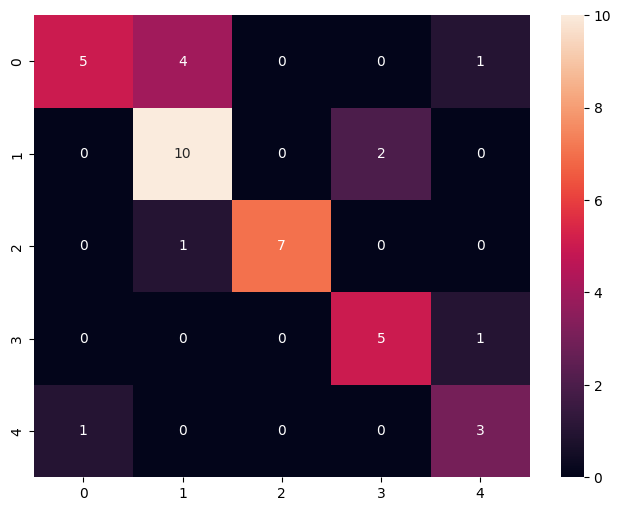

LogisticRegression               precision    recall  f1-score   support

           1       0.83      0.50      0.62        10
           2       0.79      0.92      0.85        12
           3       1.00      0.88      0.93         8
           4       0.71      0.83      0.77         6
           5       0.50      0.75      0.60         4

    accuracy                           0.78        40
   macro avg       0.77      0.78      0.75        40
weighted avg       0.80      0.78      0.77        40

F1 Score:  0.7547435897435897


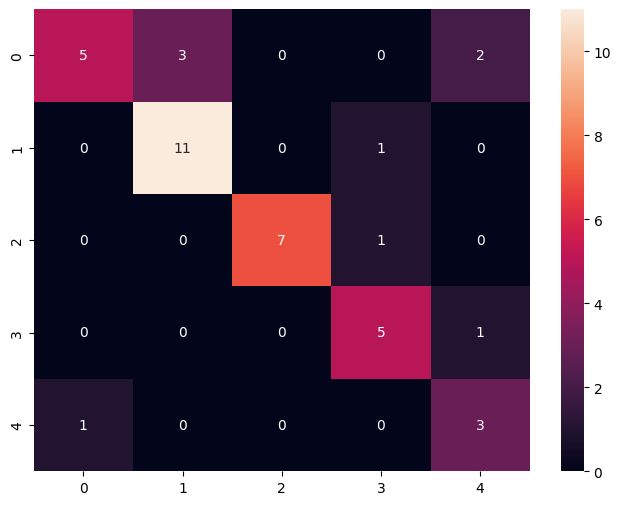

In [56]:
result_multinomial = MultinomialNB_Model(X_train, X_test, y_train, y_test)
result_logistic = LogisticRegression_Model(X_train, X_test, y_train, y_test)
#result_extra_trees = ExtraTreesClassifier_Model(X_train, X_test, y_train, y_test)
#result_random_forest = RandomForestClassifier_Model(X_train, X_test, y_train, y_test)
#result_kmeans = Kmeans_Model(X_train, X_test, y_train, y_test)

### Word2Vec

Попробуем использовать другой метод для построения векторов слов с надеждой, что он даст лучший результат на той же модели

In [52]:
import gensim

w2v_model = gensim.models.Word2Vec(full_prepared_data['lemmatized_tokens'], vector_size=100, window=5, min_count=1, workers=2)
w2v_model.train(full_prepared_data['lemmatized_tokens'], total_examples=w2v_model.corpus_count, epochs=10)
w2v_model.wv.index_to_key


['банк',
 'карта',
 'кредитный',
 'ваш',
 'мочь',
 'какой',
 'кредит',
 'интернет',
 'мой',
 'узнать',
 'хотеть',
 'приложение',
 'оформить',
 'мобильный',
 'получить',
 'услуга',
 'оплатить',
 'делать',
 'другой',
 'баланс',
 'счёт',
 'документ',
 'свой',
 'перевод',
 'онлайн',
 'текущий',
 'срок',
 'страховка',
 'деньга',
 'действие',
 'покупка',
 'автомобиль',
 'продлить',
 'проверить',
 'оплата',
 'условие',
 'нужный',
 'комиссия',
 'лимит',
 'оформление',
 'возможность',
 'операция',
 'коммунальный',
 'предоставляться',
 'помочь',
 'взять',
 'задолженность',
 'сайт',
 'ипотека',
 'платёж',
 'изменить',
 'информация',
 'страхование',
 'сделать',
 'найти',
 'заблокировать',
 'увеличить',
 'иметься',
 'доступ',
 'погасить',
 'банкомат',
 'история',
 'нужно',
 'перевести',
 'рассказать',
 'это',
 'рассрочка',
 'получение',
 'войти',
 'заявка',
 'автокредит',
 'наличный',
 'жильё',
 'отказать',
 'жизнь',
 'рейтинг',
 'способ',
 'украсть',
 'использование',
 'подтверждение',
 'окончание

Теперь проверим эффективность нового векторного представления на прошлой модели

ExtraTreesClassifier               precision    recall  f1-score   support

           1       0.43      0.30      0.35        10
           2       0.70      0.58      0.64        12
           3       0.78      0.88      0.82         8
           4       0.38      0.50      0.43         6
           5       0.33      0.50      0.40         4

    accuracy                           0.55        40
   macro avg       0.52      0.55      0.53        40
weighted avg       0.56      0.55      0.55        40

F1 Score:  0.5282811306340718


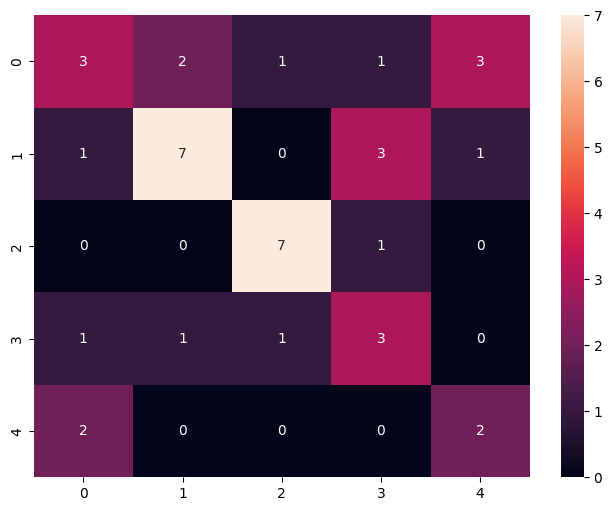

/root/.cache/pypoetry/virtualenvs/megaoplympai--lAllZs3-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.cache/pypoetry/virtualenvs/megaoplympai--lAllZs3-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.cache/pypoetry/virtualenvs/megaoplympai--lAllZs3-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

LogisticRegression               precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         8
           4       0.15      1.00      0.26         6
           5       0.00      0.00      0.00         4

    accuracy                           0.15        40
   macro avg       0.03      0.20      0.05        40
weighted avg       0.02      0.15      0.04        40

F1 Score:  0.05217391304347826


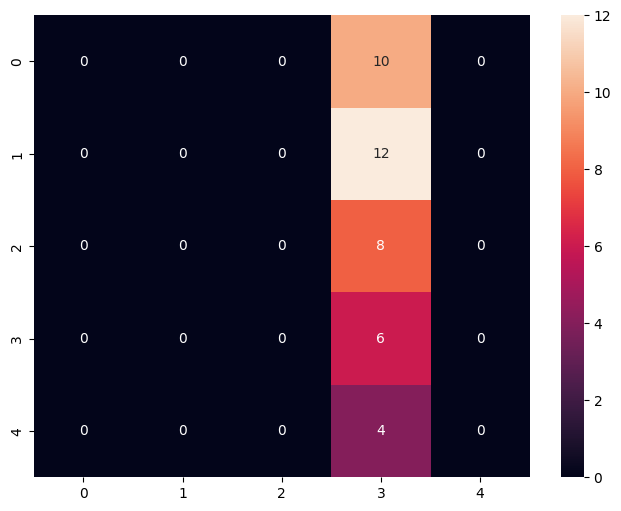

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier


words = set(w2v_model.wv.index_to_key )

X_vec = np.array([
    np.mean([w2v_model.wv[i] for i in sentence if i in words], axis=0) 
    for sentence in full_prepared_data['lemmatized_tokens']
])

X_train_vec, X_test_vec, y_train, y_test = train_test_split(X_vec, full_prepared_data['label'], test_size=0.2, random_state=42)

result_extra_trees = ExtraTreesClassifier_Model(X_train_vec, X_test_vec, y_train, y_test)
result_logistic = LogisticRegression_Model(X_train_vec, X_test_vec, y_train, y_test)


### Результат сравнения TFIDF и Word2Vec векторизации

По итогу TFIDF на малых объемах данных оказывается лучше, чем Word2Vec. 
Также лучшей моделью на TFIDF оказалась логистическая регрессия, будем пытаться улучшить на ней Score

### Получение результата

Получим валидационные данные

In [26]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


test_data = pd.read_csv('../data/test_data.csv')
validate_data = pd.read_csv('../data/validate.csv')


test_data_processed = prepare_data_for_modeling(test_data)
validate_data_processed = prepare_data_for_modeling(validate_data)

vectorizer = TfidfVectorizer()

train_text = test_data_processed['lemmatized'].apply(lambda x: ' '.join(x))
validate_text = validate_data_processed['lemmatized'].apply(lambda x: ' '.join(x))
combined_text = pd.concat([train_text, validate_text], ignore_index=True)

X = vectorizer.fit_transform(combined_text)

X_train = X[:len(train_text)]
y_train = test_data_processed['label']

model = LogisticRegression()
model.fit(X_train, y_train)

X_validate = X[len(train_text):]
y_pred = model.predict(X_validate)

validate_data_processed['predicted_label'] = y_pred
validate_data_processed[['text', 'predicted_label']].to_csv('predicted_labels.csv', index=False)

print(classification_report(y_true=None, y_pred=y_pred))


InvalidParameterError: The 'y_true' parameter of classification_report must be an array-like or a sparse matrix. Got None instead.